In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

from keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import GridSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
os.getcwd()
os.chdir('C:\\Users\\hayou\\Desktop\\Hayeon\\Columbia\\2022 Fall\\ML\\Final project')

In [3]:
df = pd.read_csv(r'C:\\Users\\hayou\\Desktop\\Hayeon\\Columbia\\2022 Fall\\ML\\Final project\\ML_Brazil.csv')
df.head()

,year,code,df_,fr_,uf,estado,municipio,popcode,pop,capital,...,milho,soja,area,west,dfper,actualFPM,bovino,CFEM,mining,sand
0,2004,1100015,73.410683,3178.279277,11,Rondônia,Alta Floresta D'Oeste,1.0,29001,0,...,7725.0,100.0,7066.702,1,0.010388,3806682.42,356520.0,1715,24892.0,0.0
1,2004,1100031,20.045996,333.670267,11,Rondônia,Cabixi,3.0,7421,0,...,2200.0,1500.0,1314.355,1,0.015252,1659323.25,126470.0,0,0.0,0.0
2,2004,1100056,16.522153,732.942001,11,Rondônia,Cerejeiras,5.0,17217,0,...,2500.0,7184.0,2783.305,1,0.005936,3318646.22,95498.0,0,0.0,0.0
3,2004,1100064,8.973859,223.336046,11,Rondônia,Colorado do Oeste,6.0,18349,0,...,4000.0,1400.0,1451.058,1,0.006184,3709075.22,226997.0,0,0.0,0.0
4,2004,1100072,8.171861,810.900208,11,Rondônia,Corumbiara,7.0,9411,0,...,3500.0,6000.0,3060.318,1,0.002670,1659323.25,281191.0,0,0.0,0.0


In [4]:
#Assign X and y
list(df.columns)

#create forest ratio
df['frper']=df['fr_']/df['area']
df=df.dropna(subset=['frper','pop','PIB_pc','actualFPM','road','crop','bovino', 'CFEM'])
y=pd.DataFrame(df, columns=['frper'])
X=pd.DataFrame(df, columns=['year','code','pop','PIB_pc','actualFPM','road','crop','bovino', 'CFEM'])
X

,year,code,pop,PIB_pc,actualFPM,road,crop,bovino,CFEM
0,2004,1100015,29001,6034.159857,3806682.42,15465.80,27355,356520.0,1715
1,2004,1100031,7421,8203.643444,1659323.25,38667.00,9240,126470.0,0
2,2004,1100056,17217,8285.490039,3318646.22,253430.07,13831,95498.0,0
4,2004,1100072,9411,9963.625970,1659323.25,345546.98,12647,281191.0,0
5,2004,1100080,11731,4738.743244,2342573.99,77388.82,2795,79145.0,0
...,...,...,...,...,...,...,...,...,...
3918,2012,5108055,10929,13951.304510,6426748.71,2538859.55,5650,265438.0,31473
3919,2012,5108501,10414,34741.481280,6426748.71,0.00,206490,29094.0,0
3920,2012,5108600,22258,13004.427710,9699357.95,2824164.83,28400,709879.0,376
3921,2012,5108907,6989,39060.547150,4607710.53,137024.00,166870,82379.0,0


In [5]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.1, random_state = 1)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size = 0.20, random_state = 1)

In [6]:
print("Training set: {} {}".format(X_train_df.shape, y_train_df.shape))  
print("Testing set:  {} {}".format(X_test_df.shape, y_test_df.shape)) 

Training set: (2771, 9) (2771, 1)
Testing set:  (693, 9) (693, 1)


### shuffle training data

In [7]:
# Shuffle the training set
X_train_df = shuffle(X_train_df, random_state=1)
y_train_df = shuffle(y_train_df, random_state=1)

#order = np.argsort(np.random.random(y_train.shape))
#X_train = X_train[order]
#y_train = y_train[order]

### data standardization / normalization

In [8]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)
X_train_df.head()

(2771, 9) (2771, 1) (693, 9)


,year,code,pop,PIB_pc,actualFPM,road,crop,bovino,CFEM
3847,1.442287,2.176297,-0.838165,2.571414,-0.016252,-0.161071,1.384704,-0.267500,-0.057613
2788,0.675925,-0.081590,-0.503756,-0.449624,0.167961,0.850557,-0.271463,-0.691223,-0.058313
3800,1.442287,-0.079929,0.250589,0.965853,1.052203,1.516295,-0.277820,-0.107358,-0.045864
2853,0.675925,2.176140,0.119476,0.738529,0.388669,-0.285240,0.702604,2.656364,-0.026209
1228,-0.856799,-0.372726,-0.784592,-0.574192,-1.060060,-0.363312,-0.295183,-0.508677,-0.058695


# CNN

# from summer ML

batch_size = 30  
# Let's build a convnet model...
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
#import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.


        model = Sequential()
        model.add(Conv2D(filters=416, kernel_size=2, padding='valid', activation='relu', input_shape=[3532,7]))
        #model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=4128, kernel_size=2, padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        model.add(Conv2D(filters=8256, kernel_size=2, padding='valid', activation='relu'))
        #model.add(Conv2D(filters=16448, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))

        #model.add(Conv2D(filters=32896, kernel_size=2, padding='same', activation='relu'))
       # model.add(Conv2D(filters=65664, kernel_size=2, padding='same', activation='relu'))
        #model.add(MaxPooling2D(pool_size=2))

        model.add(Flatten())
        model.add(Dense(50, activation='relu')) 
        model.add(Dense(505, activation='relu')) 

        model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Fitting the NN to the Training set...
        hist = model.fit(X_train_np, y_train_np,
                          epochs=1, verbose=1, validation_data=(X_test_np, y_test_np))  #y_test np?

model.summary()

# From ML fall 2022

n_filters = 32
weight_initializer = 'glorot_uniform' # glorot uniform is used as weight initializer for each deconvolution layer
alpha_leaky_relu   = 0.01
l1_regularization = 0
l2_regularization = 4e-3
regularizer = l1_l2(l1=l1_regularization, l2=l2_regularization) # base: l1_l2(l1=0.0001, l2=0), 
learning_rate  = 1e-3
minibatch_size = 64
num_epochs     = 200

model = Sequential()

model.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), kernel_initializer=weight_initializer))
model.add(LeakyReLU(alpha=alpha_leaky_relu))
model.add(Reshape((12,18,n_filters)))

# Upsample to 24x36
model.add(Conv2DTranspose(filters=n_filters, kernel_regularizer=regularizer, #2D bec lon, lat만 하고 filter accross 로는 안 해서
                          kernel_initializer=weight_initializer, 
                          kernel_size=(4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=alpha_leaky_relu))

# Upsample to 48x72
model.add(Conv2DTranspose(filters=n_filters, kernel_regularizer=regularizer, 
                          kernel_initializer=weight_initializer, 
                          kernel_size=(4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=alpha_leaky_relu))

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_regularizer=regularizer, 
                          kernel_initializer=weight_initializer, 
                          kernel_size=(4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=alpha_leaky_relu))


model.add(Conv2D(filters=1, kernel_size=(5,5), kernel_regularizer=regularizer, #필터 크기 1 (그냥 최종 이미지 맵이니까)
                 kernel_initializer=weight_initializer, activation='linear', padding='same'))

optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

# NN (Not CNN since it is not spatial data)

### What are the hyper parameters?
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

순서가 일단 모델 define (Dense 이런 거 하고. ) 
- complie 
- model = KerasClassifier(model=create_model, verbose=0)

#Function to create model, required for KerasClassifier
def create_model(neurons):

 #create model
 model = Sequential()
 model.add(Dense(neurons, input_shape=(8,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(4)))
 model.add(Dropout(0.2))
 model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
 
 #Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model
 
#fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

#define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

#optimizer 고르는 부분일아 batch size 등등 고르는 부분이랑 다른데 걍 합쳐서 짜깁기 해둠
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

    
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)


neurons = [1, 5, 10, 15, 20, 25, 30]

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Note the function create_model() defined above does not return a compiled model like that one in the previous example. This is because setting an optimizer for a Keras model is done in the compile() function call; hence it is better to leave it to the KerasClassifier wrapper and the GridSearchCV model. Also, note that you specified loss="binary_crossentropy" in the wrapper as it should also be set during the compile() function call.

# Use scikit-learn to grid search the number of neurons
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
#from scikeras.wrappers import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.constraints import MaxNorm
# Function to create model, required for KerasClassifier
def create_model(neurons):
    # create model
    model=Sequential()
    model.add(Dense(neurons, input_shape=(8,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(4)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
NNmodel = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [1, 32, 64]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=NNmodel, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Use scikit-learn to grid search the learning rate and momentum
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(8,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	return model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)
# load dataset
dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", optimizer="SGD", epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

위에 버리고 그냥 몇 개만 튜닝하자
### Tuning hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = {'num_epochs': [1, 5, 10, 50, 100, 200],
              'learning_rate': [0.0001, 0.0005, 0.001, 0.005]}


#GridsearchCV from ML for Soc Sci
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=10)

grid.fit(X_train_scaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}\n".format(grid.score(X_test_scaled, y_test)))

#ML for soc sci
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
model = Sequential([
Dense(hidden_size, input_shape=(784,)),
Activation('relu'),
Dense(10),
Activation('softmax'),
])
model.compile(optimizer=optimizer,loss="categorical_crossentropy",
metrics=['accuracy'])
return model
clf = KerasClassifier(make_model)

param_grid = {'epochs': [1, 5, 10], # epochs is fit parameter, not in make_model!
'hidden_size': [32, 64, 256]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size"],
values=['mean_train_score', "mean_test_score"])

In [38]:
# set hyperparameters
#n_neuron       = 64 
activation     = 'relu'
#num_epochs     = 200
learning_rate  = 0.0001 #보통 10^-4
minibatch_size = 64
model_num      = 1

#ML for soc sci
from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
    model = Sequential()
    model.add(Dense(64,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
    model.add(Dense(64,  activation=activation)) #Gridsearch CV에서 값 어떻게 반영하지?
    model.add(Dense(32,  activation=activation)) 
    model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model
clf = KerasRegressor(make_model)

param_grid = {'epochs': [1, 5, 10], # epochs is fit parameter, not in make_model!
'hidden_size': [32, 64, 256]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)


#12/13아래는 돌아가는 버전. 건드리지 말기. learning_rate 는 cv 포함하려다 에러나서 웨이웨이 문의상태

In [41]:
#여기 경우에 적용
#https://www.adriangb.com/scikeras/stable/migration.html
#https://www.nbshare.io/notebook/584445049/Rectified-Linear-Unit-For-Artificial-Neural-Networks-Part-1-Regression/
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

#튜닝할 것들: (epoch), learning rate, layer 개수, (optimizer=adam으로 픽스하기), (activation=reLU 쓰는 듯 regression은)
def make_model(optimizer="adam", hidden_size1=32, hidden_size2=32, hidden_size3=32):
    model = Sequential()
    model.add(Dense(hidden_size1,  activation=activation,input_shape=(X_train.shape[1],))) #기존 64를 hidden size로 대체
    model.add(Dense(hidden_size2,  activation=activation)) 
    model.add(Dense(hidden_size3,  activation=activation)) 
    model.add(Dense(y_train.shape[1],  activation='linear'))

    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)
clf = KerasRegressor(make_model,verbose=1)
param_grid = {'epochs': [1, 20], # [1,20,50]으로 나중에 바꾸기. epochs is fit parameter, not in make_model! 첨에 100 200 했는데 시간 오래걸리고 200이 그리 좋진 않음.
'hidden_size1': [32, 64],
'hidden_size2': [32, 64],
'hidden_size3': [32, 64]}

C:\Users\hayou\AppData\Local\Temp\ipykernel_23944\270790579.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasRegressor(make_model,verbose=1)


def make_model():
    model = Sequential()
    model.add(Dense(32,  activation=activation,input_shape=(X_train.shape[1],))) 
    model.add(Dense(32,  activation=activation)) 
    model.add(Dense(32,  activation=activation)) 
    model.add(Dense(y_train.shape[1],  activation='linear'))

    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learn_rate), metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

model=make_model()
model.compile()
clf= KerasRegressor(model)
#clf = KerasRegressor(model=make_model, loss="mse", optimizer="Adam", epochs=100, batch_size=10, verbose=0)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learn_rate)

In [42]:
grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

18/18 [==============================] - 0s 1ms/step - loss: 0.0915 - accuracy: 0.1137
Epoch 1/20
70/70 [==============================] - 1s 2ms/step - loss: 0.2024 - accuracy: 0.0979
Epoch 2/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1673 - accuracy: 0.0979
Epoch 3/20
70/70 [==============================] - 0s 3ms/step - loss: 0.1524 - accuracy: 0.0979
Epoch 4/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1435 - accuracy: 0.0979
Epoch 5/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.0979
Epoch 6/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.0979
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1266 - accuracy: 0.0975
Epoch 8/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 0.0975
Epoch 9/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1191 - accuracy: 0.0979
Epoch 10/20
70/70 [============

70/70 [==============================] - 0s 2ms/step - loss: 0.1092 - accuracy: 0.0975
Epoch 14/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1072 - accuracy: 0.0975
Epoch 15/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1054 - accuracy: 0.0975
Epoch 16/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1036 - accuracy: 0.0975
Epoch 17/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1019 - accuracy: 0.0975
Epoch 18/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1002 - accuracy: 0.0975
Epoch 19/20
70/70 [==============================] - 0s 1ms/step - loss: 0.0986 - accuracy: 0.0975
Epoch 20/20
18/18 [==============================] - 0s 1ms/step - loss: 0.2067 - accuracy: 0.0901
Epoch 1/20
70/70 [==============================] - 1s 1ms/step - loss: 0.1780 - accuracy: 0.0970
Epoch 2/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.0970
Epoch 3/20
70/70 [======

70/70 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.0916
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.0916
Epoch 14/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1462 - accuracy: 0.0916
Epoch 15/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1441 - accuracy: 0.0920
Epoch 16/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1420 - accuracy: 0.0916
Epoch 17/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.0916
Epoch 18/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1383 - accuracy: 0.0911
Epoch 19/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.0920
Epoch 20/20
18/18 [==============================] - 0s 1ms/step - loss: 0.0606 - accuracy: 0.1137
Epoch 1/20
70/70 [==============================] - 1s 1ms/step - loss: 0.4111 - accuracy: 0.0979
Epoch 2/20
70/70 [=====

70/70 [==============================] - 0s 2ms/step - loss: 0.1381 - accuracy: 0.1001
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1361 - accuracy: 0.1001
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1333 - accuracy: 0.1001
Epoch 14/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1315 - accuracy: 0.1001
Epoch 15/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1296 - accuracy: 0.1001
Epoch 16/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1276 - accuracy: 0.1006
Epoch 17/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.1006
Epoch 18/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1247 - accuracy: 0.1006
Epoch 19/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1229 - accuracy: 0.1006
Epoch 20/20
18/18 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.0794
Epoch 1/20
70/70 [====

70/70 [==============================] - 0s 2ms/step - loss: 0.1473 - accuracy: 0.0938
Epoch 11/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1442 - accuracy: 0.0938
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.0938
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1391 - accuracy: 0.0938
Epoch 14/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1370 - accuracy: 0.0938
Epoch 15/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1347 - accuracy: 0.0938
Epoch 16/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1325 - accuracy: 0.0938
Epoch 17/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1303 - accuracy: 0.0938
Epoch 18/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1287 - accuracy: 0.0938
Epoch 19/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1273 - accuracy: 0.0938
Epoch 20/20
18/18 [===

70/70 [==============================] - 0s 2ms/step - loss: 0.1124 - accuracy: 0.0974
Epoch 10/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1095 - accuracy: 0.0974
Epoch 11/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1069 - accuracy: 0.0974
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1048 - accuracy: 0.0974
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1025 - accuracy: 0.0974
Epoch 14/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1005 - accuracy: 0.0974
Epoch 15/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0985 - accuracy: 0.0974
Epoch 16/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0965 - accuracy: 0.0974
Epoch 17/20
70/70 [==============================] - 0s 1ms/step - loss: 0.0945 - accuracy: 0.0974
Epoch 18/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0927 - accuracy: 0.0974
Epoch 19/20
70/70 [===

70/70 [==============================] - 0s 2ms/step - loss: 0.1056 - accuracy: 0.0979
Epoch 9/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1025 - accuracy: 0.0979
Epoch 10/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1002 - accuracy: 0.0979
Epoch 11/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0981 - accuracy: 0.0979
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0963 - accuracy: 0.0979
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0948 - accuracy: 0.0979
Epoch 14/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0933 - accuracy: 0.0979
Epoch 15/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0922 - accuracy: 0.0979
Epoch 16/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0913 - accuracy: 0.0979
Epoch 17/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.0979
Epoch 18/20
70/70 [====

70/70 [==============================] - 0s 2ms/step - loss: 0.1589 - accuracy: 0.0911
Epoch 8/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.0911
Epoch 9/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1509 - accuracy: 0.0920
Epoch 10/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1475 - accuracy: 0.0920
Epoch 11/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1437 - accuracy: 0.0920
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1410 - accuracy: 0.0920
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.0920
Epoch 14/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.0920
Epoch 15/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.0920
Epoch 16/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1301 - accuracy: 0.0920
Epoch 17/20
70/70 [=====

70/70 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.0997
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1421 - accuracy: 0.1006
Epoch 8/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1387 - accuracy: 0.1006
Epoch 9/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1356 - accuracy: 0.1001
Epoch 10/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1329 - accuracy: 0.1001
Epoch 11/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1301 - accuracy: 0.1006
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.1006
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.1006
Epoch 14/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1243 - accuracy: 0.1006
Epoch 15/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1226 - accuracy: 0.1006
Epoch 16/20
70/70 [======

70/70 [==============================] - 0s 2ms/step - loss: 0.1393 - accuracy: 0.0938
Epoch 6/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.0938
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1315 - accuracy: 0.0938
Epoch 8/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1282 - accuracy: 0.0938
Epoch 9/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1251 - accuracy: 0.0938
Epoch 10/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1232 - accuracy: 0.0938
Epoch 11/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1206 - accuracy: 0.0938
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1189 - accuracy: 0.0938
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1168 - accuracy: 0.0938
Epoch 14/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1152 - accuracy: 0.0938
Epoch 15/20
70/70 [=======

70/70 [==============================] - 0s 2ms/step - loss: 0.1148 - accuracy: 0.0961
Epoch 5/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.0970
Epoch 6/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1043 - accuracy: 0.0974
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1007 - accuracy: 0.0974
Epoch 8/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0970 - accuracy: 0.0974
Epoch 9/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.0974
Epoch 10/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0910 - accuracy: 0.0974
Epoch 11/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0885 - accuracy: 0.0974
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0862 - accuracy: 0.0974
Epoch 13/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0842 - accuracy: 0.0974
Epoch 14/20
70/70 [========

87/87 [==============================] - 0s 2ms/step - loss: 0.1404 - accuracy: 0.0964
Epoch 4/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.0964
Epoch 5/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1294 - accuracy: 0.0964
Epoch 6/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1252 - accuracy: 0.0964
Epoch 7/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1214 - accuracy: 0.0964
Epoch 8/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1184 - accuracy: 0.0964
Epoch 9/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1152 - accuracy: 0.0964
Epoch 10/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1127 - accuracy: 0.0964
Epoch 11/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1104 - accuracy: 0.0964
Epoch 12/20
87/87 [==============================] - 0s 2ms/step - loss: 0.1084 - accuracy: 0.0964
Epoch 13/20
87/87 [=========

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002B9C3863070>,
             param_grid={'epochs': [1, 20], 'hidden_size1': [32, 64],
                         'hidden_size2': [32, 64], 'hidden_size3': [32, 64]})

In [43]:
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size1","param_hidden_size2","param_hidden_size3"],
#values=['mean_train_score', "mean_test_score"])
values=["mean_test_score","rank_test_score"])

#negative value 바로잡기

mean_test_score  \
param_epochs param_hidden_size1 param_hidden_size2 param_hidden_size3                    
1            32                 32                 32                        -0.186712   
                                                   64                        -0.169665   
                                64                 32                        -0.203116   
                                                   64                        -0.174919   
             64                 32                 32                        -0.187939   
                                                   64                        -0.178731   
                                64                 32                        -0.188816   
                                                   64                        -0.179330   
20           32                 32                 32                        -0.124930   
                                                   64                        -0.127830   
                                64                 32                        -0.122910   
                                                   64                        -0.125013   
             64                 32                 32                        -0.117897   
                                                   64                        -0.114955   
                                64                 32                        -0.111563   
                                                   64                        -0.115980   

                                                                       rank_test_score  
param_epochs param_hidden_size1 param_hidden_size2 param_hidden_size3                   
1            32                 32                 32                               13  
                                                   64                                9  
                                64                 32                               16  
                                                   64                               10  
             64                 32                 32                               14  
                                                   64                               11  
                                64                 32                               15  
                                                   64                               12  
20           32                 32                 32                                6  
                                                   64                                8  
                                64                 32                                5  
                                                   64                                7  
             64                 32                 32                                4  
                                                   64                                2  
                                64                 32                                1  
                                                   64                                3

In [44]:
#parameter tuning 전 모델인데, 위에 cv에서 나온 파라미터들을 넣기
model = Sequential()

model.add(Dense(64,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(64,  activation=activation)) #Gridsearch CV에서 값 어떻게 반영하지?
model.add(Dense(32,  activation=activation)) 
#model.add(Dense('hidden_size',  activation=activation)) 
#model.add(Dense('hidden_size',  activation=activation)) 
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer

model.summary()

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

Model: "sequential_405"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1620 (Dense)          (None, 64)                640       
                                                                 
 dense_1621 (Dense)          (None, 64)                4160      
                                                                 
 dense_1622 (Dense)          (None, 32)                2080      
                                                                 
 dense_1623 (Dense)          (None, 1)                 33        
                                                                 
Total params: 6,913
Trainable params: 6,913
Non-trainable params: 0
_________________________________________________________________


grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(self.model, X_train, y_train)
scoring="accuracy"
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size"],
values=['mean_train_score', "mean_test_score"])

#kf = cross_validation.KFold(len(X_train), n_folds=10)
#score = cross_val_score(self.model, X_train, Y_train, cv=kf, n_jobs=-1).mean()

## fit the training data

In [45]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, #위에서 fit 을 define 했었음
                    batch_size      = minibatch_size,
                    epochs          = 20,
                    validation_split= 0.2, #train loss
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/20
35/35 [==============================] - 1s 7ms/step - loss: 0.2246 - accuracy: 0.0921 - val_loss: 0.1047 - val_accuracy: 0.1135
Epoch 2/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.0912 - val_loss: 0.0895 - val_accuracy: 0.1117
Epoch 3/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1786 - accuracy: 0.0894 - val_loss: 0.0823 - val_accuracy: 0.1117
Epoch 4/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1685 - accuracy: 0.0903 - val_loss: 0.0767 - val_accuracy: 0.1117
Epoch 5/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1601 - accuracy: 0.0912 - val_loss: 0.0714 - val_accuracy: 0.1117
Epoch 6/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1535 - accuracy: 0.0912 - val_loss: 0.0670 - val_accuracy: 0.1117
Epoch 7/20
35/35 [==============================] - 0s 3ms/step - loss: 0.1480 - accuracy: 0.0912 - val_loss: 0.0634 - val_accuracy: 0.1117
Epoch 8/20
35/35 [==

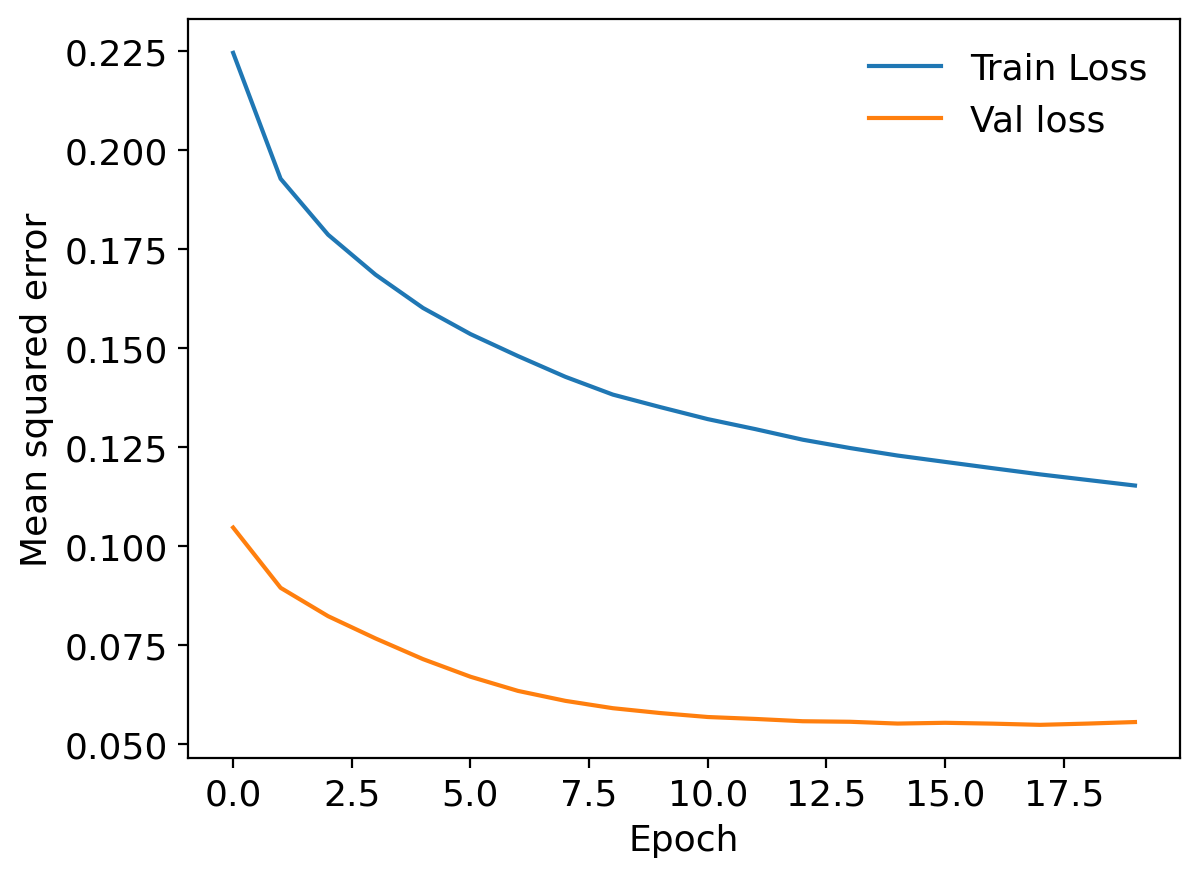

In [46]:
plot_history(history)

In [14]:
#save model
model_path = './saved_model/'
make_dir(model_path)

In [15]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(model_path+'NN_model.h5')

### Evaluate the trained model

In [16]:
#reload the saved model
#model = load_model(model_path+'NN_model.h5')

#classification의 경우의 evaluation이라 버리기. 
score = model.evaluate(X_test, y_test, batch_size=minibatch_size)  #one hot code 뭔지 찾아보기: #그럼 이제 이게 tabular data with 1 col = 1개 class만 1이고 나머진 0이고 그렇게 쭈루룩 있는, one hot encode 된 거 
#onehotEncode before you fit tyour model 뭔가 classification 아니면 필요 없을듯

print(score) #loss, accuracy

Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
loss가 MSE 이고, evaluation에는 MAE로 나오는듯


In [49]:
print('Available Metrics in Model: {}'.format(model.metrics_names))

Available Metrics in Model: ['loss', 'accuracy']


In [50]:
model.evaluate(X_test, y_test, verbose=0)  #아 그럼 loss 가 MSE 니까 MSE, MAE 다 나온 건가

[0.15827463567256927, 0.09235209226608276]

In [48]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0)
print(mae)
#print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

0.09235209226608276


### predict

22/22 [==============================] - 0s 918us/step


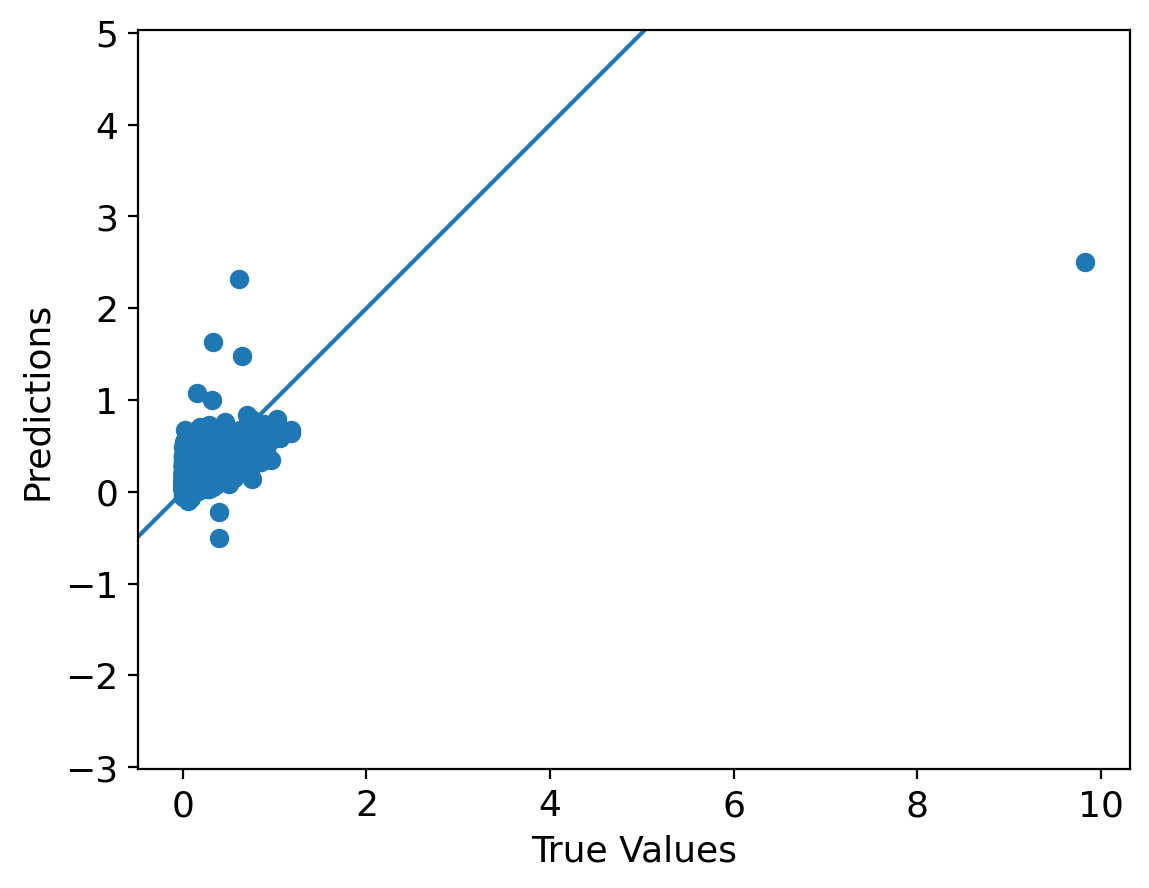

In [18]:
#keras_boston housing price에서 옴
#test_predictions = model.predict(test_data).flatten()  #flatten 왜하지
y_test_pred = model.predict(X_test)

plt.scatter(y_test, y_test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [23]:
print(y_test[y_test<3].shape)
print(y_test_pred[y_test_pred<2.5].shape)
print(max(y_test))
print(max(y_test_pred))

(692,)
(692,)
[9.82556661]
[2.50335]


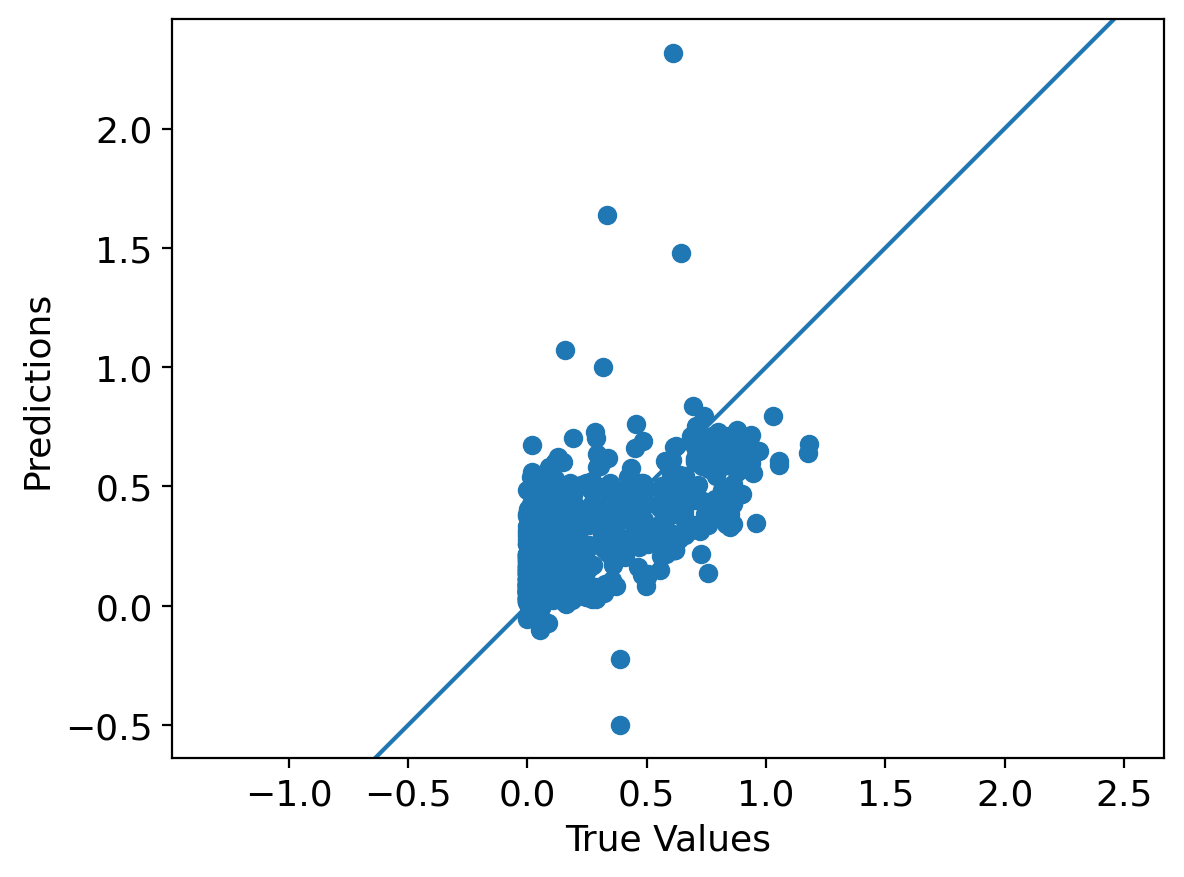

In [26]:
# Rule out the outlier
plt.scatter(y_test[y_test<3], y_test_pred[y_test_pred<2.5])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [27]:
np.corrcoef(y_test,y_test_pred)[0,1]

C:\Users\hayou\anaconda3\envs\keras\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\hayou\anaconda3\envs\keras\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\hayou\anaconda3\envs\keras\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


nan

In [28]:
from sklearn.metrics import r2_score
r2_score(y_test,y_test_pred) #poor job.

0.369227442484069

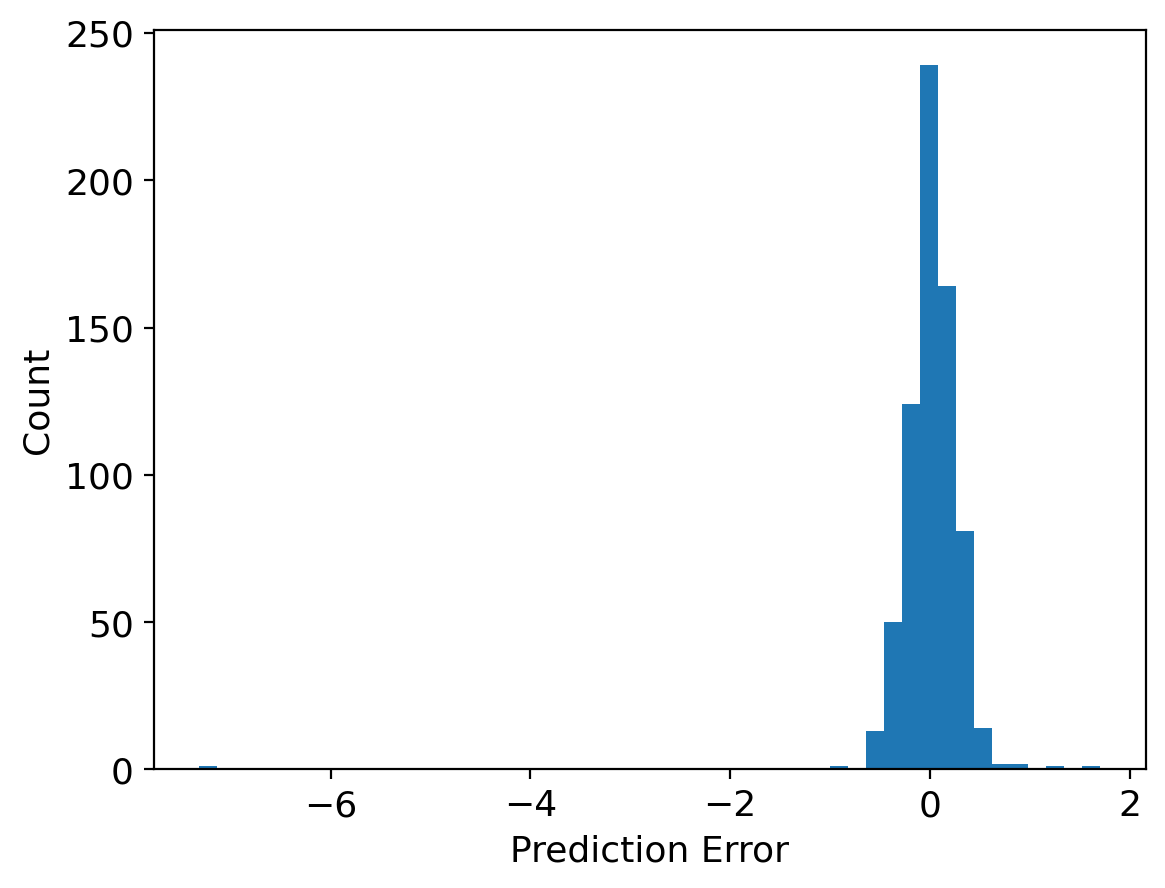

In [29]:
error = y_test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
#residual should look normal. There is one with error of -8.

Conclusion
This notebook introduced a few techniques to handle a regression problem.

Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).  
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).  
When input data features have values with different ranges, each feature should be scaled independently.  
If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.  
Early stopping is a useful technique to prevent overfitting

# RNN LSTM

Reshape data to feed into the LSTM model

The LSTM needs data with the format of [samples, time steps, n_latitude, n_longitude, n_features]

Here the lag time step is set to 5

n_filters   = 20
kernal_size = 3
pool_size   = 2
n_lstm_unit = 25
activation  = 'relu'
learning_rate = 0.001
minibatch_size = 64
num_epochs     = 50

model = Sequential()

model.add(Input(shape=(slider, n_lat,n_lon,n_feature)))
model.add(TimeDistributed(Conv2D(n_filters, (kernal_size, kernal_size), #convolutional layer여기
                                     padding='same', activation=activation), input_shape=(slider, n_lat,n_lon,n_feature)))
model.add(TimeDistributed(AveragePooling2D(pool_size)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(n_lstm_unit, activation=activation)) #lstm here. 얘의 위치. lower dimensional space에서 보통 함.
model.add(Dense(n_lat*n_lon))
model.add(Activation('linear'))
model.add(Reshape((1, n_lat, n_lon)))


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)) #cross enthropy로 mse를 바꾸면 classfication 할 수 있음.
model.summary()

# Tree
얘는 validation data 따로 안 나누는 거 같음

In [51]:
import seaborn as sns
# gradient boosting 
from xgboost import XGBRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# evaluation metrics
from sklearn.metrics import mean_squared_error

In [52]:
#======================================================
# setup model parameters, choose RFR or XGB
# if you comment out a parameter it will use default value
#======================================================
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':1000,  #number of trees
              'criterion':'mse', 
              #'ccp_alpha':0.001,
              'max_depth': 10,
              #'min_samples_leaf':1,
              #'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}


# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              #'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 2000,  # number of trees to use
              'learning_rate': 0.01, 
              'max_depth': 30,       # how many levels are in each tree
              #'subsample': 1,
              #'colsample_bytree': 0.8,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 1,  #regularization. looks simialar to NN. weight 일 수 있음. 걍 MSE에 대비해서 얼마나 punish할 거냐 쓰는 거라 1000도 쓸 수 있음. 
              'reg_lambda': 0,}



## Random Forest

Random forest의 파라미터
n_estimators: Number of trees to generate for model
max_depth: tunes the number of times internal nodes are split. (i.e.-tree size)
max_features: - Number of randomly selected features per split. 랜덤포래스트 고유
criterion: 'gini' or 'entropy' for classification and 'mse' for regression
min_samples_leaf: set threshold for minimum number of observations per terminal node. (also a tree size parameter)
oob_score: returns out of bag score in model fit object. Extract result by printing the 'estimators_features_' from model fit object.

In [43]:
model = RandomForestRegressor(**params_rfr) #**:뒤의 파라미터를 passing to the model. 
#model = XGBRegressor(**params_xgb)

### Train the model

In [44]:
%%time
model.fit(X_train, y_train)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\hayou\anaconda3\envs\keras\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


CPU times: total: 9.83 s
Wall time: 9.82 s


RandomForestRegressor(criterion='mse', max_depth=10, max_features=None,
                      n_estimators=1000)

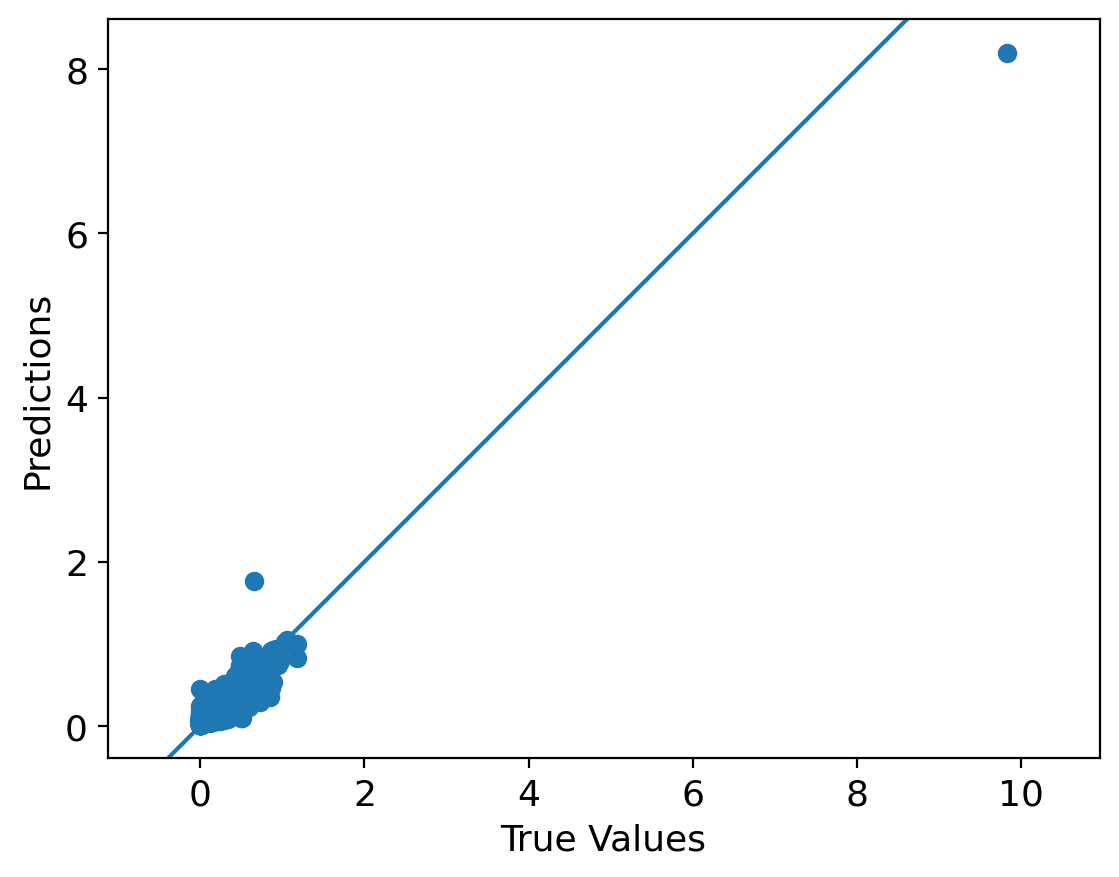

In [45]:
test_pred = model.predict(X_test)  #이전에 model.evaluate 처럼 비슷. 이번엔 predict함.

plt.scatter(y_test, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

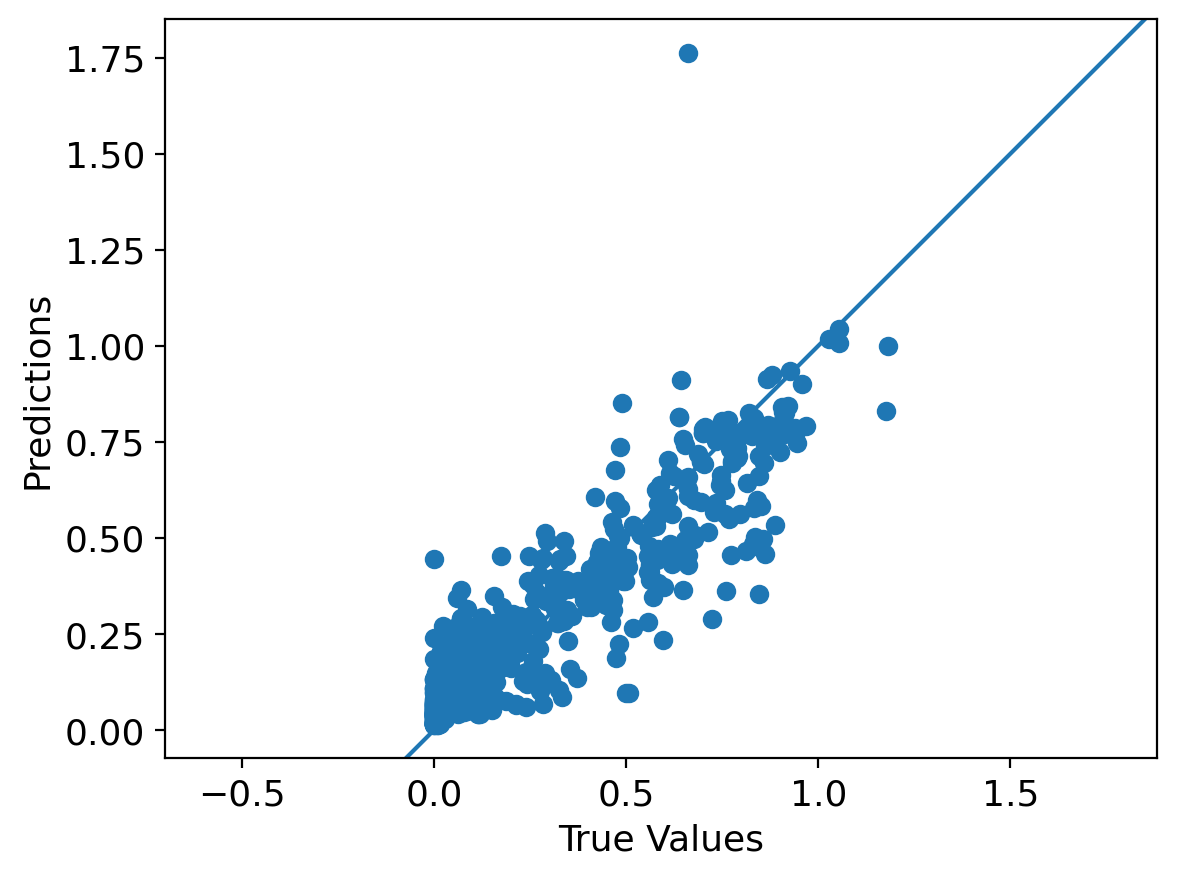

In [46]:
plt.scatter(y_test[y_test<2], test_pred[test_pred<2])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

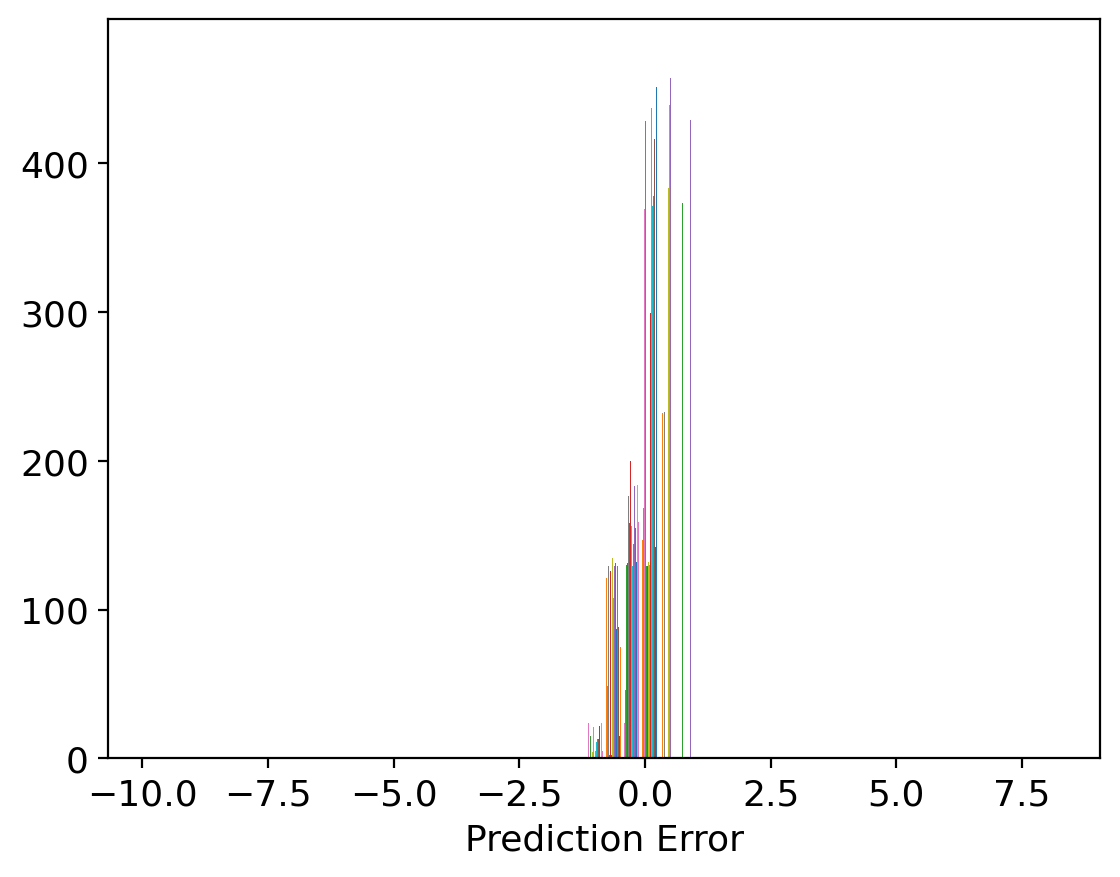

In [47]:
# histogram
error = test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.show()

In [48]:
mse = mean_squared_error(y_test, test_pred)
print(f'the mse is {mse}')

the mse is 0.018507733639150925


In [54]:
from sklearn.metrics import r2_score
r2_score(y_test,test_pred)  #rf가 더 better than xgb. cuz data size is small, shuffle and bootstrp better?
print(f'the R-squared is {r2_score(y_test,test_pred)}')

NameError: name 'test_pred' is not defined

### Feature importance

In [53]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

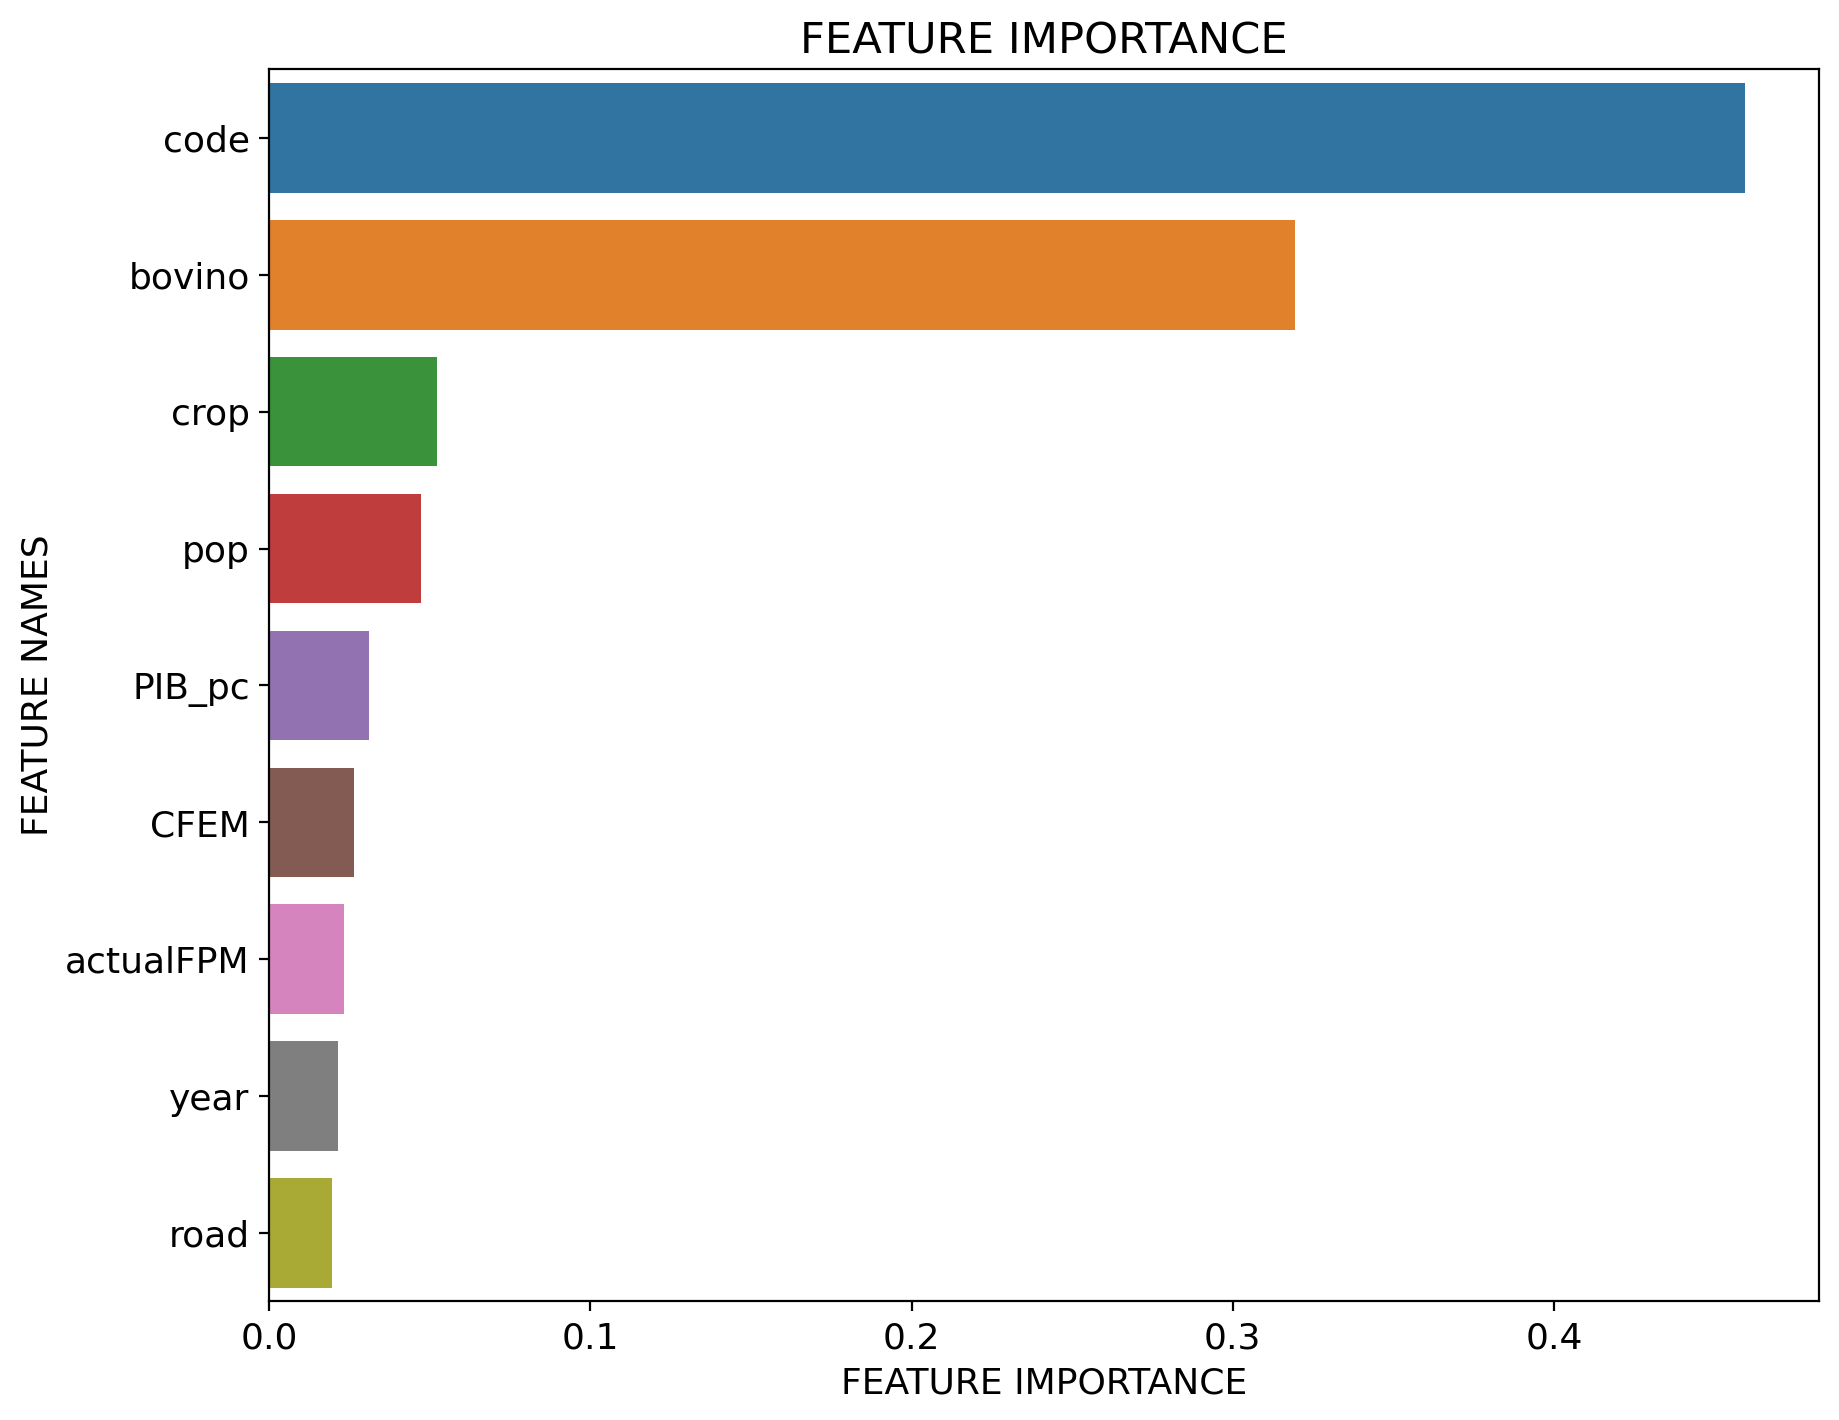

In [51]:
#plot_feature_importance(model.feature_importances_, df.columns)  #model.feature_importances 걍 이용 가능. 그 하나 빼놓고 하고 해서 랭킹
plot_feature_importance(model.feature_importances_, X_train_df.columns)  #model.feature_importances 걍 이용 가능. 그 하나 빼놓고 하고 해서 랭킹

## Tree- XGB

In [57]:
model = XGBRegressor(**params_xgb)
%time
model.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=30, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1, reg_lambda=0, ...)

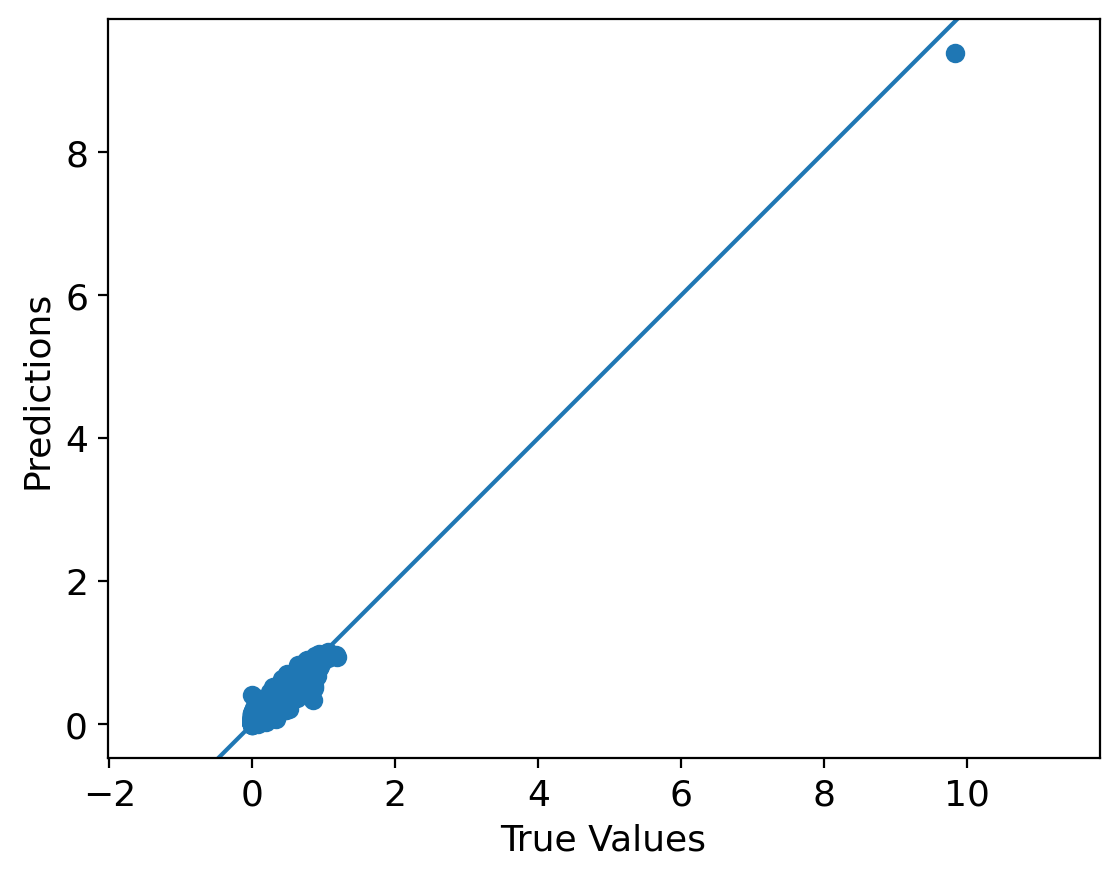

In [58]:
test_pred = model.predict(X_test)  #이전에 model.evaluate 처럼 비슷. 이번엔 predict함.

plt.scatter(y_test, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
#Zoom in to the scatterplot
plt.scatter(y_test[y_test<2], test_pred[test_pred<2])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

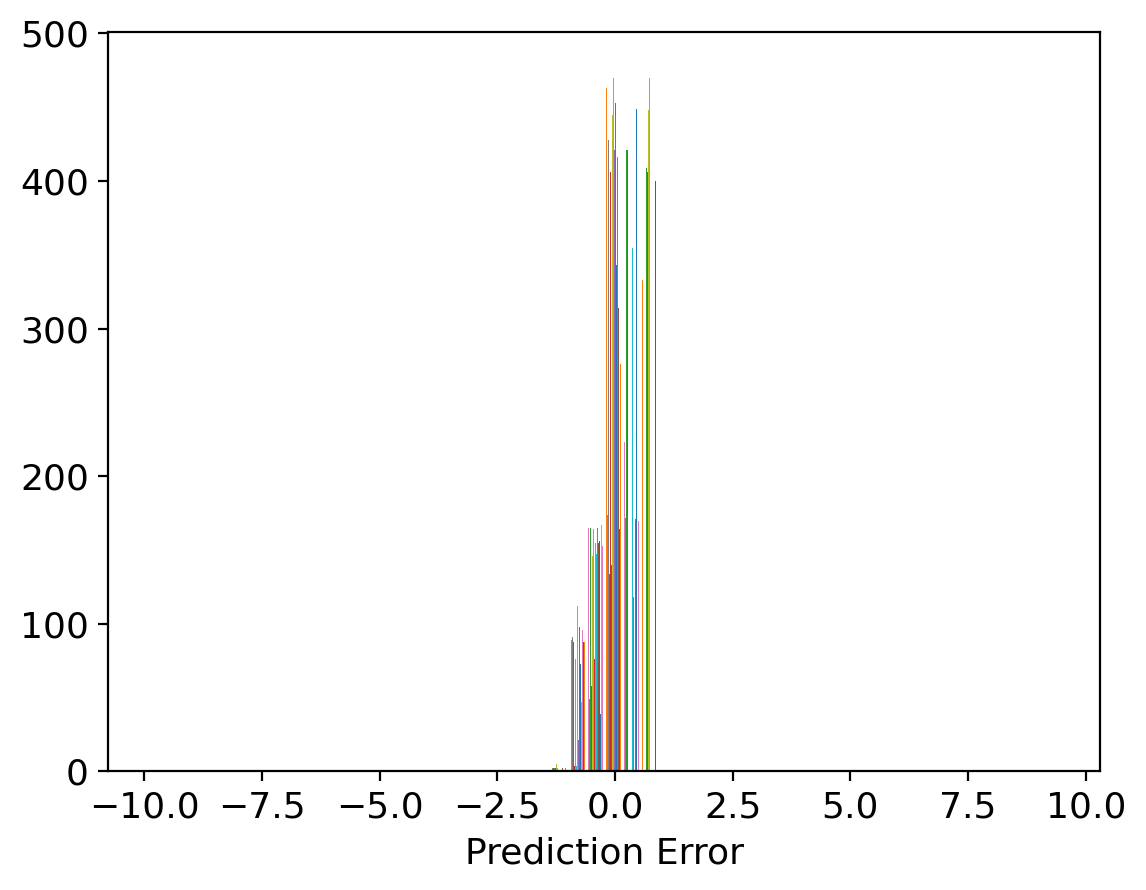

In [59]:
# histogram
error = test_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.show()

In [60]:
mse = mean_squared_error(y_test, test_pred)
print(f'the mse is {mse}')
from sklearn.metrics import r2_score
r2_score(y_test,test_pred) 
print(f'the R-squared is {r2_score(y_test,test_pred)}')

the mse is 0.009034017716319096
the R-squared is 0.95785024573898


### Feature importance

def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [ ]:
X_train_df.columns

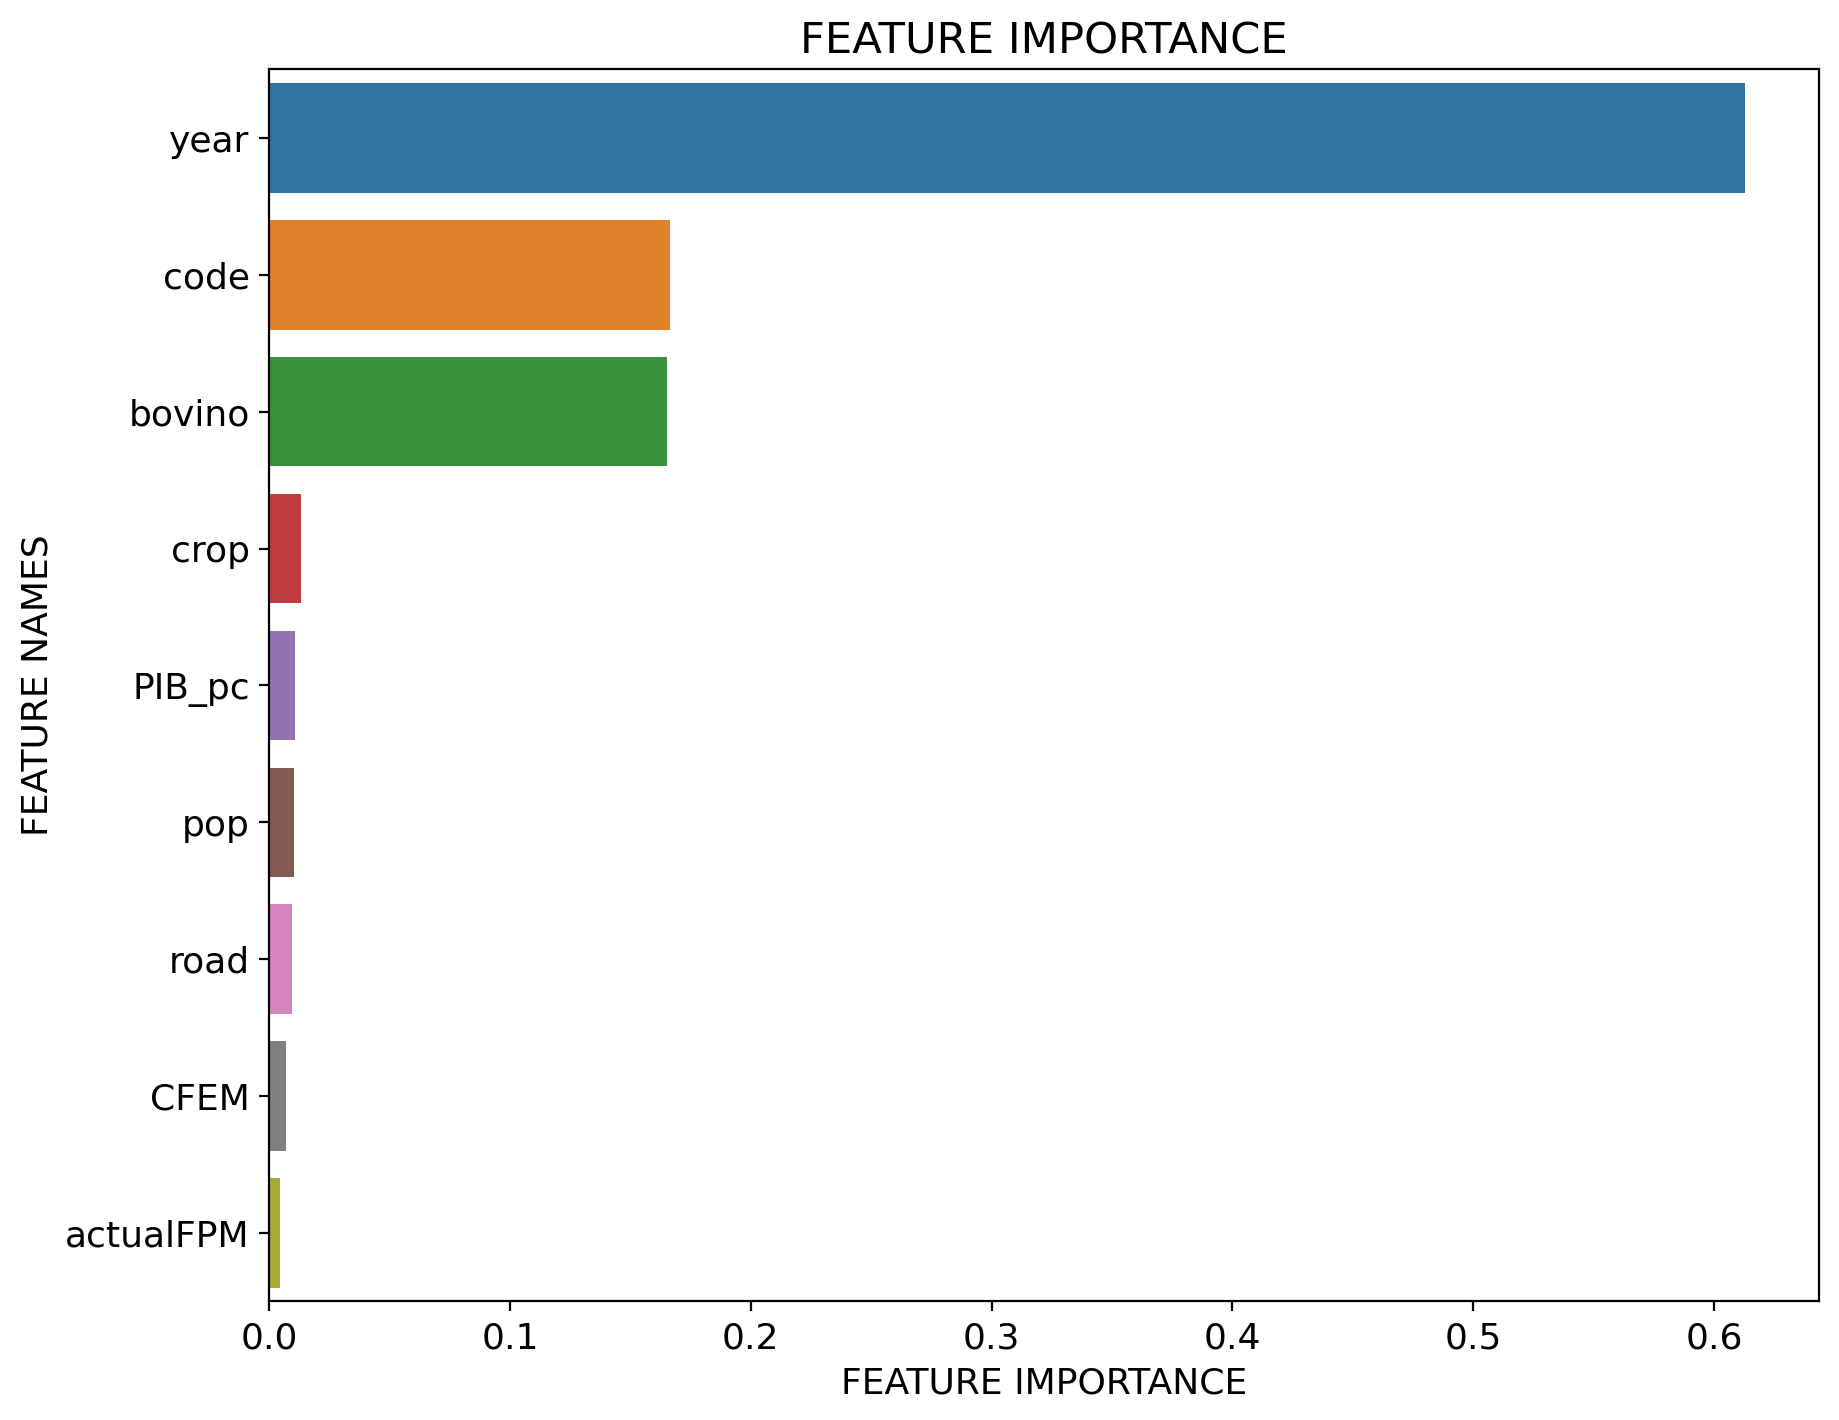

In [61]:
#plot_feature_importance(model.feature_importances_, df.columns)  #model.feature_importances 걍 이용 가능. 그 하나 빼놓고 하고 해서 랭킹
plot_feature_importance(model.feature_importances_, X_train_df.columns)  #model.feature_importances 걍 이용 가능. 그 하나 빼놓고 하고 해서 랭킹

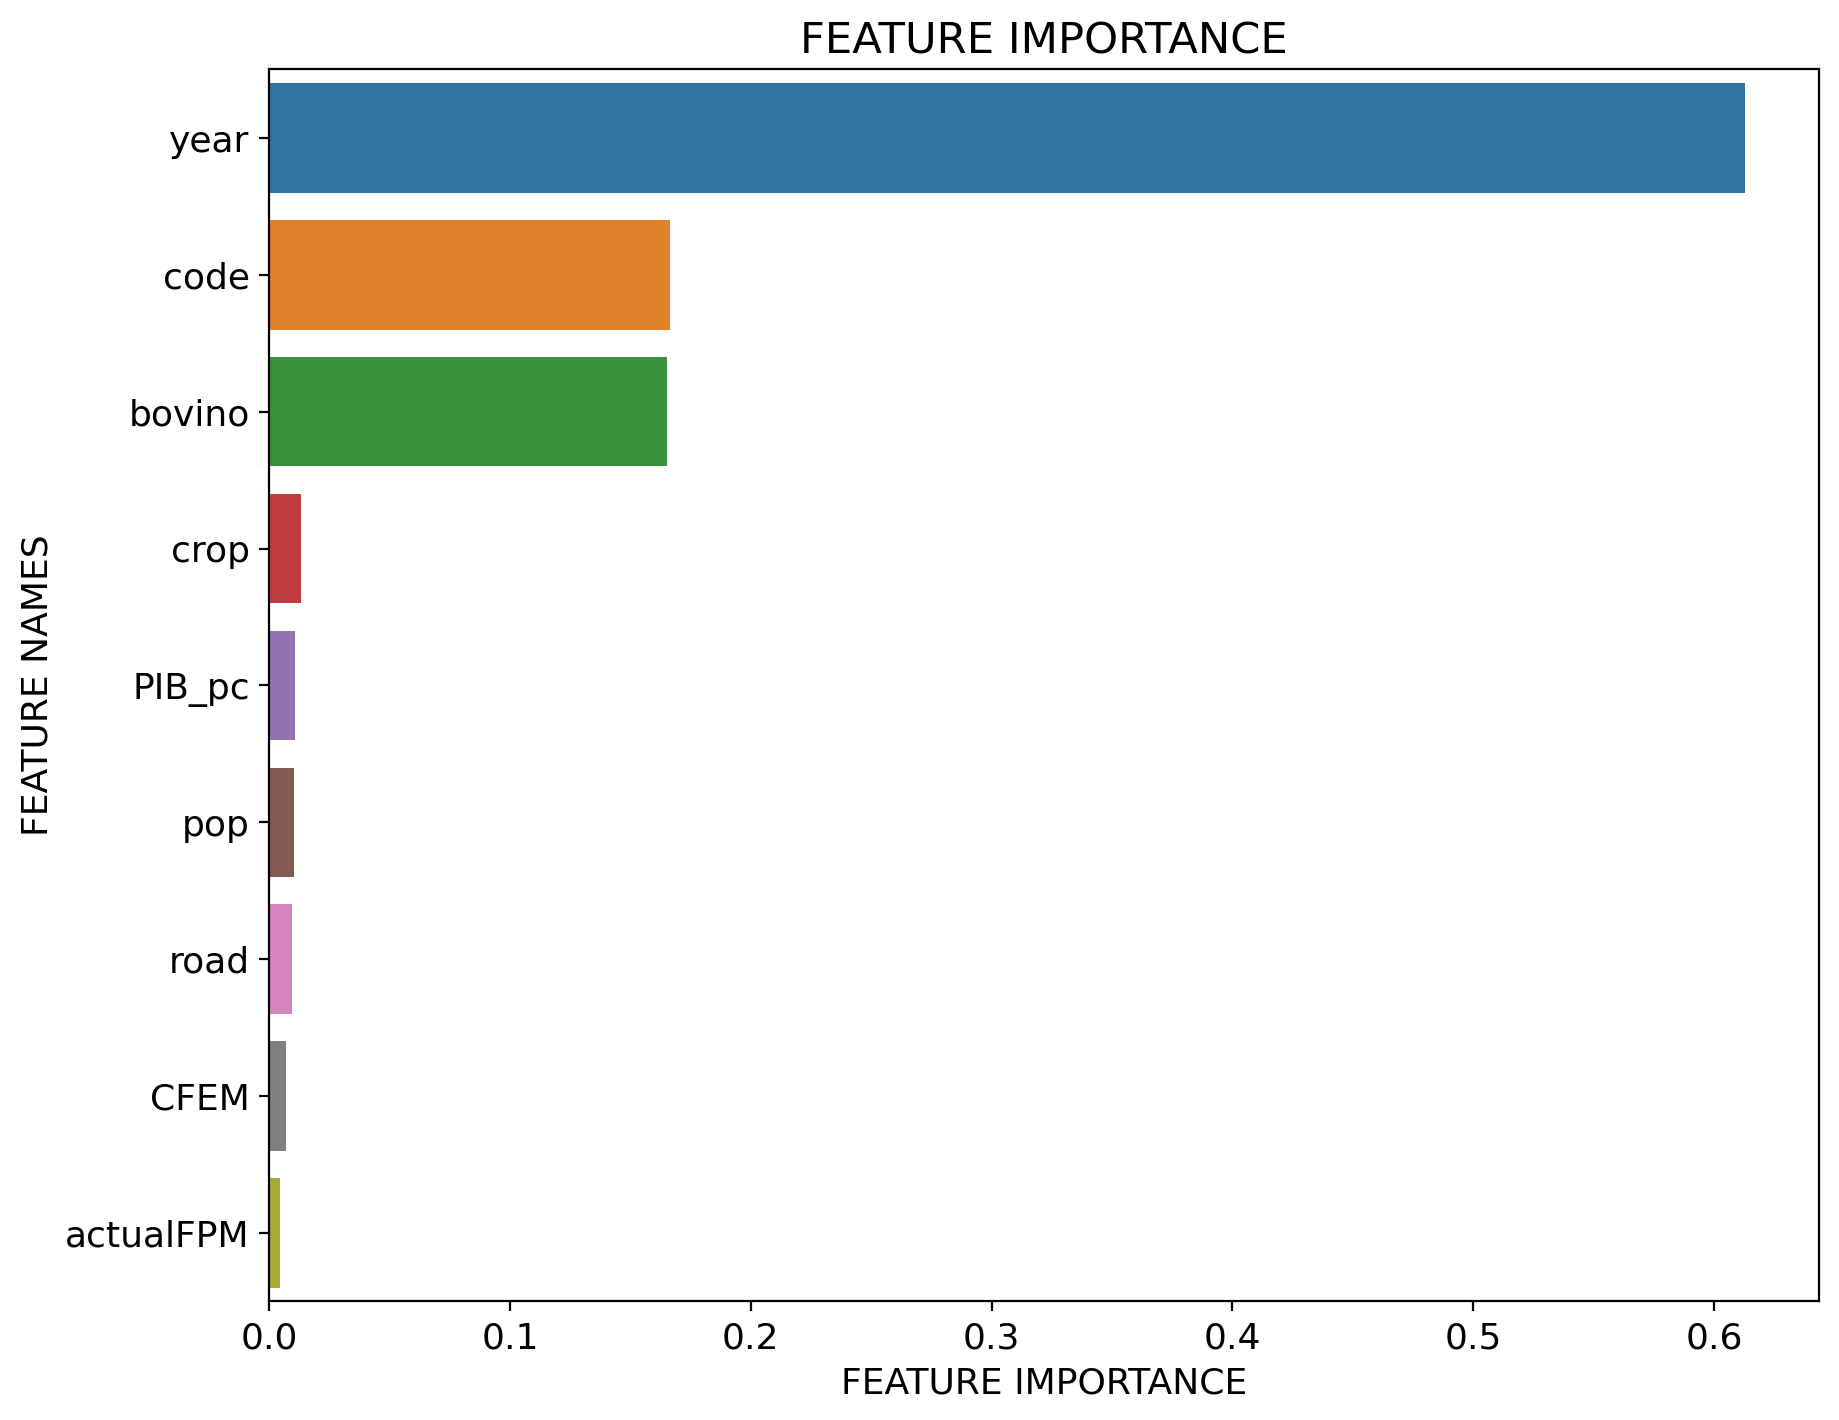

In [62]:
#plot_feature_importance(model.feature_importances_, df.columns)  #model.feature_importances 걍 이용 가능. 그 하나 빼놓고 하고 해서 랭킹
plot_feature_importance(model.feature_importances_, X_test_df.columns)